# Imports

In [1]:
import os
import re

In [2]:
import numpy as np
import pandas as pd
import scipy as sp

In [3]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
MAPBOX_STYLE = "dark"
MAPBOX_HEIGHT = 800
%matplotlib inline
import matplotlib.font_manager
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

px.set_mapbox_access_token(os.getenv("MAPBOX_TOKEN"))
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
plt.style.use("seaborn-colorblind")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Open Sans"
plt.rcParams["figure.figsize"] = 15, 6
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [5]:
import matplotlib.image as img
from scipy.cluster.hierarchy import fcluster, linkage

# unique to this nb
from scipy.cluster.vq import kmeans, vq
from sklearn.feature_extraction.text import TfidfVectorizer

# Functions

In [6]:
def plot_elbow_distortions(data, n_clusters=10):
    # Create a list of distortions from the kmeans function
    distortions = []
    num_clusters = range(1, n_clusters)
    for i in num_clusters:
        cluster_centers, distortion = kmeans(data, i)
        distortions.append(distortion)

    # Create a data frame with two lists - number of clusters and distortions
    elbow_plot = pd.DataFrame(
        {"num_clusters": num_clusters, "distortions": distortions}
    )

    # Creat a line plot of num_clusters and distortions
    sns.lineplot(x="num_clusters", y="distortions", data=elbow_plot)

In [7]:
def plot_clusters(data, n_clusters):
    # Generate cluster centers
    cluster_centers, distortion = kmeans(data, n_clusters)

    # Assign cluster labels
    cluster_labels, distortion_list = vq(data, cluster_centers)

    # Plot clusters
    sns.scatterplot(data, hue=cluster_labels)

In [8]:
def remove_noise(text):
    import nltk
    from nltk.corpus import stopwords

    stop_words = set(stopwords.words("english"))
    tokens = nltk.word_tokenize(text)
    cleaned_tokens = []
    for token in tokens:
        token = re.sub("[^A-Za-z0-9]+", "", token)
        if len(token) > 1 and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

# FIFA

## Data

In [9]:
fifa = pd.read_csv("datasets/fifa_18_sample_data.csv").clean_names()
fifa.drop_duplicates(inplace=True)
fifa.drop("id", axis=1, inplace=True)
fifa = fifa.select_dtypes(include=["number"])
print(fifa.shape)
fifa.sample(5)

(1000, 79)


,special,age,height_cm,weight_kg,eur_value,eur_wage,eur_release_clause,overall,potential,pac,...,cb,lb,lwb,ls,lf,lam,lcm,ldm,lcb,gk
81,1612,29,190.0,80.0,30000000.0,60000.0,57000000.0,85,85,56,...,83.0,72.0,68.0,52.0,48.0,47.0,55.0,74.0,83.0,NaN
247,2062,29,190.0,91.0,17000000.0,85000.0,32300000.0,82,82,50,...,81.0,74.0,74.0,75.0,73.0,73.0,78.0,81.0,81.0,NaN
608,1764,26,180.0,74.0,15500000.0,37000.0,33700000.0,79,82,63,...,40.0,47.0,53.0,68.0,74.0,78.0,72.0,54.0,40.0,NaN
905,1888,28,191.0,91.0,9000000.0,71000.0,17100000.0,77,77,77,...,50.0,55.0,58.0,77.0,77.0,76.0,71.0,57.0,50.0,NaN
687,2000,36,174.0,75.0,1400000.0,25000.0,2700000.0,79,79,69,...,78.0,77.0,76.0,65.0,67.0,68.0,71.0,76.0,78.0,NaN


In [10]:
# fillna and preserve types
orig_dtypes = fifa.dtypes.to_dict()
fifa.fillna(0, inplace=True)
fifa = fifa.apply(lambda x: x.astype(orig_dtypes[x.name]))

## Whitening

In [11]:
# whiten columns
fifa_whitened = pd.DataFrame(sp.cluster.vq.whiten(fifa), columns=fifa.columns)

          eur_wage    eur_value
count  1000.000000  1000.000000
mean      1.119812     1.306272
std       1.000500     1.000500
min       0.000000     0.000000
25%       0.467717     0.730412
50%       0.854794     1.022576
75%       1.407184     1.542995
max       9.112425     8.984064


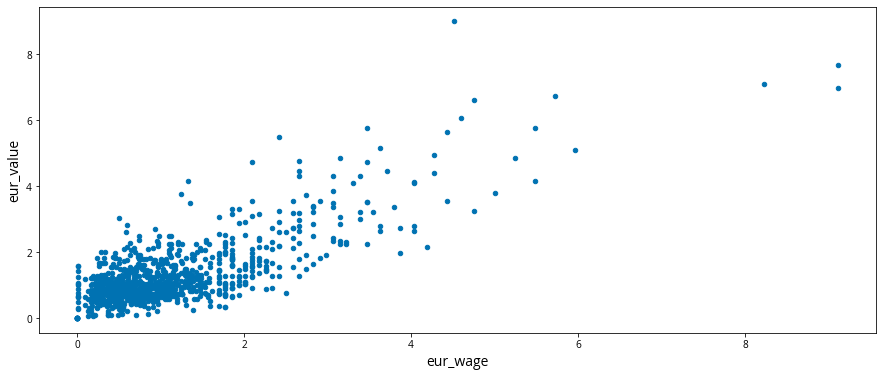

In [12]:
# Plot the two columns in a scatter plot
fifa_whitened.plot(x="eur_wage", y="eur_value", kind="scatter")

# Check mean and standard deviation of scaled values
print(fifa_whitened[["eur_wage", "eur_value"]].describe())

<div class="alert alert-block alert-warning">
<b>Whitening != Scaling</b></div>

            ss_wage      ss_value
count  1.000000e+03  1.000000e+03
mean   2.697842e-16  8.451573e-16
std    1.000500e+00  1.000500e+00
min   -1.119812e+00 -1.306272e+00
25%   -6.520948e-01 -5.758602e-01
50%   -2.650184e-01 -2.836955e-01
75%    2.873720e-01  2.367228e-01
max    7.992613e+00  7.677792e+00


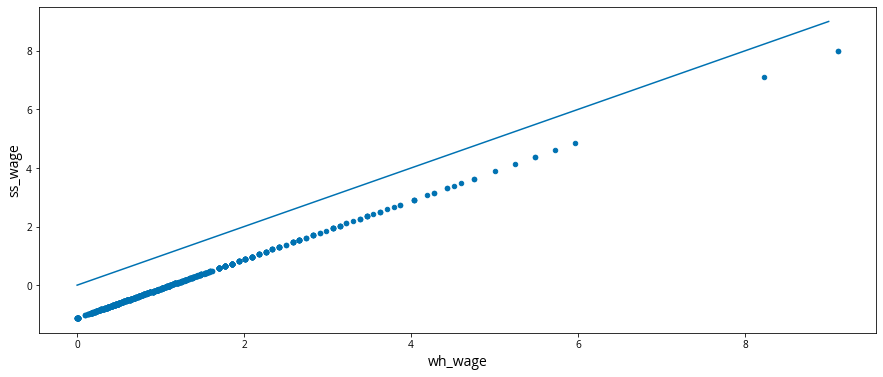

In [13]:
# standardscaler != whitening

# Scale wage and value
fifa["wh_wage"] = sp.cluster.vq.whiten(fifa["eur_wage"])
fifa["wh_value"] = sp.cluster.vq.whiten(fifa["eur_value"])

fifa["ss_wage"] = StandardScaler().fit_transform(fifa["eur_wage"].values.reshape(-1, 1))
fifa["ss_value"] = StandardScaler().fit_transform(
    fifa["eur_value"].values.reshape(-1, 1)
)
print(fifa[["ss_wage", "ss_value"]].describe())
fifa.plot(x="wh_wage", y="ss_wage", kind="scatter")
x = [_ for _ in range(0, 10)]
plt.plot(x, x)

           mm_wage     mm_value
count  1000.000000  1000.000000
mean      0.122888     0.145399
std       0.109795     0.111364
min       0.000000     0.000000
25%       0.051327     0.081301
50%       0.093805     0.113821
75%       0.154425     0.171748
max       1.000000     1.000000


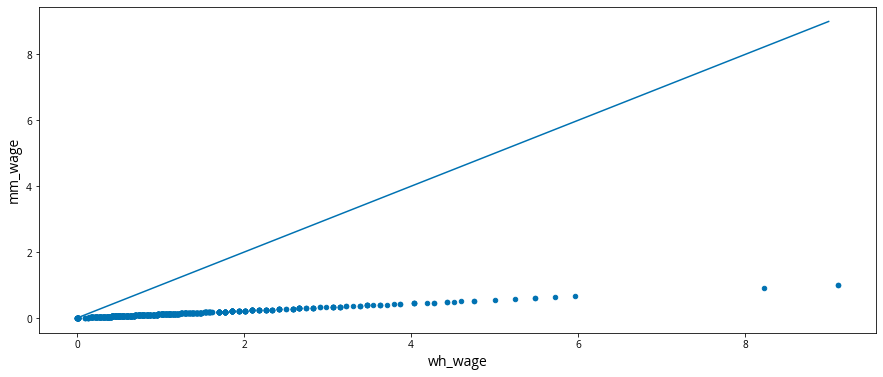

In [14]:
# minmaxscaler != whitening
fifa["mm_wage"] = MinMaxScaler().fit_transform(fifa["eur_wage"].values.reshape(-1, 1))
fifa["mm_value"] = MinMaxScaler().fit_transform(fifa["eur_value"].values.reshape(-1, 1))
print(fifa[["mm_wage", "mm_value"]].describe())
fifa.plot(x="wh_wage", y="mm_wage", kind="scatter")
x = [_ for _ in range(0, 10)]
plt.plot(x, x)

<div class="alert alert-block alert-warning">
<b></b></div>

## Hierarchical Clustering

                sliding_tackle  aggression
cluster_labels                            
1                     2.837810    4.280968
2                     0.579966    1.766698
3                     1.166930    3.415214


<AxesSubplot:xlabel='sliding_tackle', ylabel='aggression'>

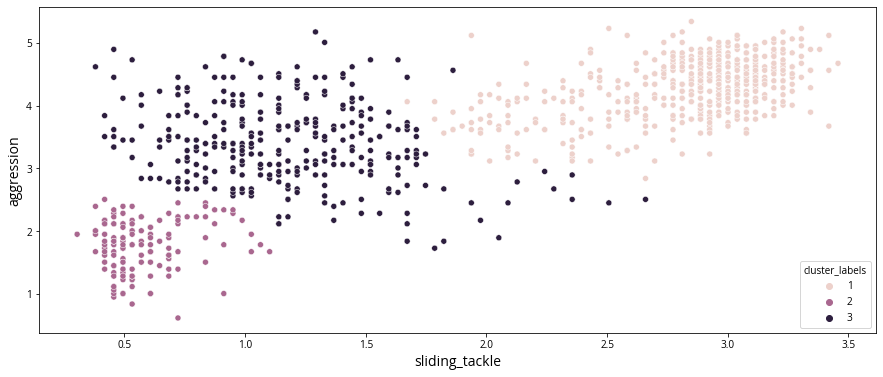

In [15]:
# Fit the data into a hierarchical clustering algorithm
distance_matrix = sp.cluster.hierarchy.linkage(
    fifa_whitened[["sliding_tackle", "aggression"]], "ward"
)

# Assign cluster labels to each row of data
fifa_whitened["cluster_labels"] = sp.cluster.hierarchy.fcluster(
    distance_matrix, 3, criterion="maxclust"
)

# Display cluster centers of each cluster
print(
    fifa_whitened[["sliding_tackle", "aggression", "cluster_labels"]]
    .groupby("cluster_labels")
    .mean()
)

# Create a scatter plot through seaborn
sns.scatterplot(
    x="sliding_tackle", y="aggression", hue="cluster_labels", data=fifa_whitened
)

In [16]:
# Print the size of the clusters
print(fifa_whitened.groupby("cluster_labels").age.count())

# Print the mean value of wages in each cluster
print(fifa_whitened.groupby("cluster_labels")["eur_wage"].mean())

cluster_labels
1    547
2    139
3    314
Name: age, dtype: int64
cluster_labels
1    1.133543
2    0.829151
3    1.224561
Name: eur_wage, dtype: float64


## Kmeans

In [17]:
interesting_features = ["pac", "sho", "pas", "dri", "def", "phy"]

# Create centroids with kmeans for 2 clusters
cluster_centers, _ = kmeans(
    fifa_whitened[interesting_features].to_numpy().astype(float), 2
)

# Assign cluster labels and print cluster centers
fifa_whitened["cluster_labels"], _ = vq(
    fifa_whitened[interesting_features], cluster_centers
)
print(fifa_whitened.groupby("cluster_labels")[interesting_features].mean())

                     pac       sho       pas       dri       def       phy
cluster_labels                                                            
0               5.444516  3.664623  7.165875  6.759972  3.967897  9.210371
1               6.684385  5.427481  8.455351  8.513096  2.504167  8.336310


<AxesSubplot:xlabel='cluster_labels'>

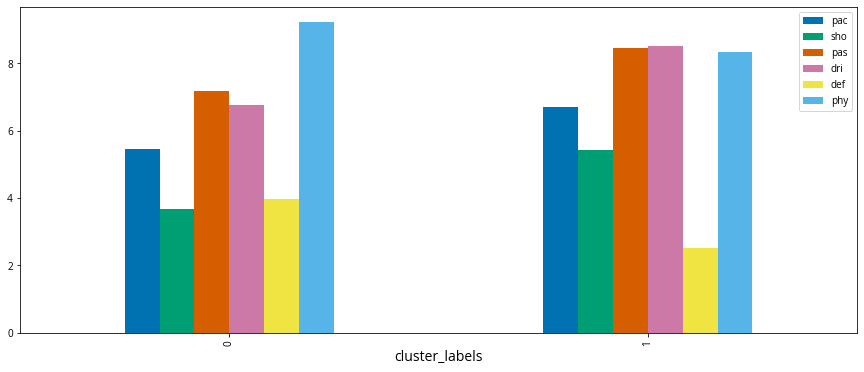

In [18]:
# Plot cluster centers to visualize clusters
fifa_whitened.groupby("cluster_labels")[interesting_features].mean().plot(
    legend=True, kind="bar"
)

In [19]:
# Get the name column of first 5 players in each cluster
for cluster in fifa_whitened["cluster_labels"].unique():
    print(
        cluster,
        fifa_whitened[fifa_whitened["cluster_labels"] == cluster]["name"].values[:5],
    )

KeyError: 'name'

# ComicCon

## Data

In [20]:
comic_con = pd.read_csv("datasets/comicon.csv", index_col=0)
comic_con.sample(5)

,x_coordinate,y_coordinate,x_scaled,y_scaled
23,93,99,2.786439,2.227744
21,88,99,2.636630,2.227744
6,14,1,0.419464,0.022502
32,25,10,0.749043,0.225025
2,35,0,1.048660,0.000000


## Hierarchical Clustering

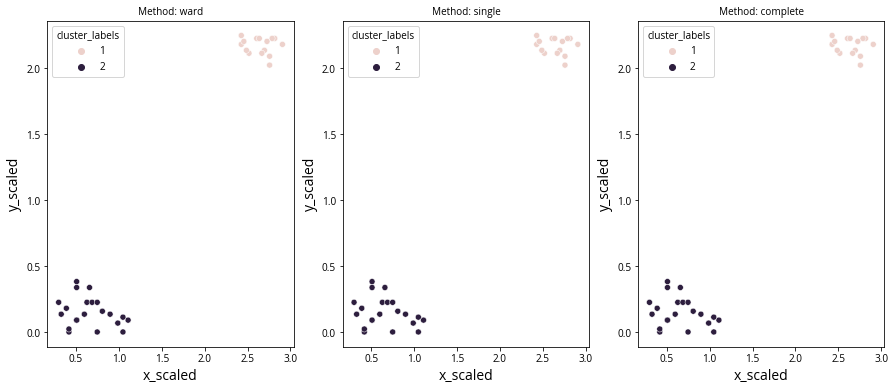

In [21]:
# plots
fig, ax = plt.subplots(1, 3)

for i, method in enumerate(["ward", "single", "complete"]):
    # Use the linkage() function
    distance_matrix = linkage(
        comic_con[["x_scaled", "y_scaled"]], method=method, metric="euclidean"
    )

    # Assign cluster labels
    comic_con["cluster_labels"] = fcluster(distance_matrix, 2, criterion="maxclust")

    # Plot clusters

    sns.scatterplot(
        x="x_scaled", y="y_scaled", hue="cluster_labels", data=comic_con, ax=ax[i]
    )
    ax[i].title.set_text(f"Method: {method}")

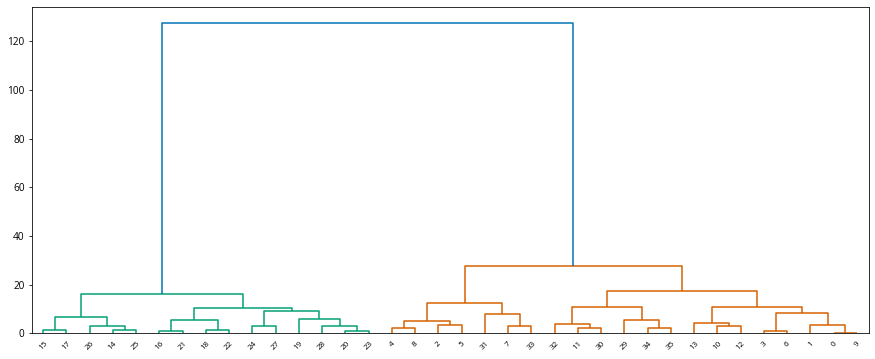

In [22]:
# Calculate the linkage: mergings
Z = sp.cluster.hierarchy.linkage(comic_con, method="complete")

# Plot the dendrogram
_ = sp.cluster.hierarchy.dendrogram(Z)

## Kmeans

## Naive `n_clusters`

<AxesSubplot:xlabel='x_scaled', ylabel='y_scaled'>

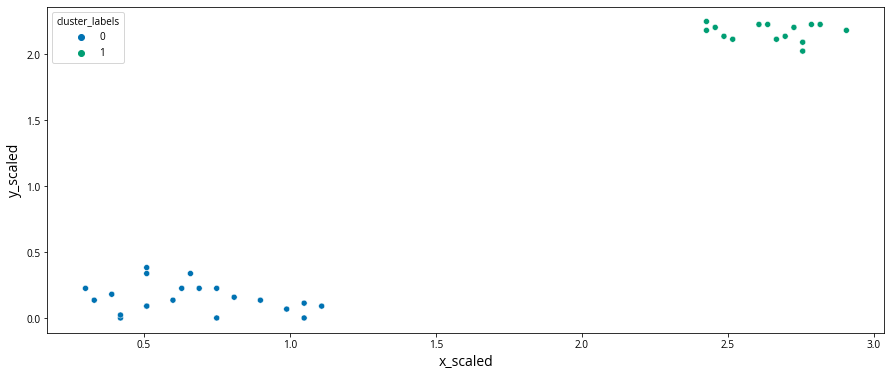

In [23]:
# Generate cluster centers
cluster_centers, distortion = kmeans(comic_con[["x_scaled", "y_scaled"]], 2)

# Assign cluster labels
comic_con["cluster_labels"], distortion_list = vq(
    comic_con[["x_scaled", "y_scaled"]], cluster_centers
)

# Plot clusters
sns.scatterplot(x="x_scaled", y="y_scaled", hue="cluster_labels", data=comic_con)

## Elbow Selection

For non-uniform data, the elbow selection method can help suggest the "right" number of clusters.
- Distortion: sum of squared distances of points from cluster centers
- Decreases with an increasing number of clusters
- Becomes zero when the number of clusters equals the number ofp oints
- Elbow plot:line plot between cluster centers and distortion


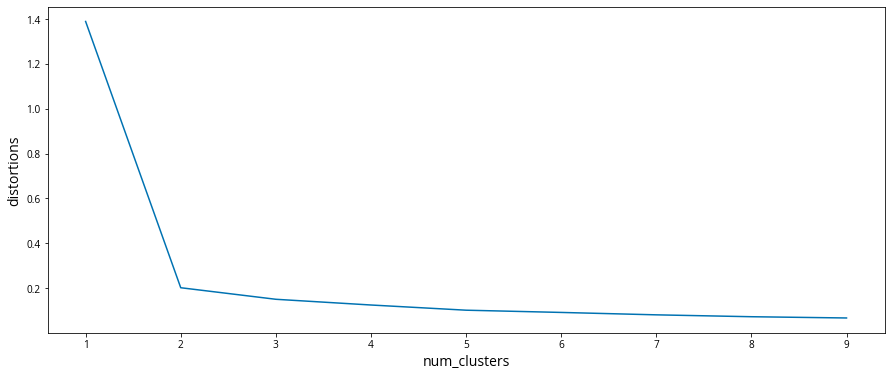

In [24]:
plot_elbow_distortions(comic_con[["x_scaled", "y_scaled"]])

Uniform data doesn't follow this behavior.

# Limitations

## Seeding

In [25]:
mouse = pd.read_csv("datasets/mouse.csv", index_col=0)
mouse.sample(10)

,x_coordinate,y_coordinate,x_scaled,y_scaled
4,62.063146,47.196944,4.047935,3.130303
33,52.688688,44.377592,3.436506,2.943312
111,28.683402,83.835794,1.870813,5.560348
68,35.566639,42.722747,2.319757,2.833555
39,48.030007,56.603803,3.132654,3.754206
18,38.028884,39.828177,2.480352,2.641575
144,62.004372,75.131064,4.044101,4.983013
119,28.676889,82.545052,1.870388,5.474741
149,79.660664,73.340171,5.195695,4.864234
124,34.287110,80.516006,2.236303,5.340166


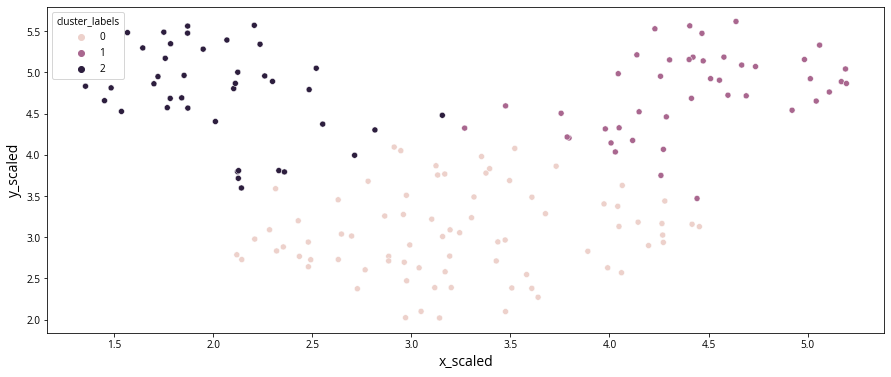

In [26]:
# Initialize seed
np.random.seed([0, 10])

# Run kmeans clustering
cluster_centers, distortion = kmeans(mouse[["x_scaled", "y_scaled"]], 3)
mouse["cluster_labels"], distortion_list = vq(
    mouse[["x_scaled", "y_scaled"]], cluster_centers
)

# Plot the scatterplot
sns.scatterplot(x="x_scaled", y="y_scaled", hue="cluster_labels", data=mouse)
plt.show()

Notice that kmeans is unable to capture the three visible clusters clearly, and the two clusters towards the top have taken in some points along the boundary. This happens due to the underlying assumption in kmeans algorithm to minimize distortions which leads to clusters that are similar in terms of area.

## Uniform Data

In [27]:
xs = np.random.uniform(-1, 1, 1000)
ys = np.random.uniform(-1, 1, 1000)
data = list(zip(xs, ys))

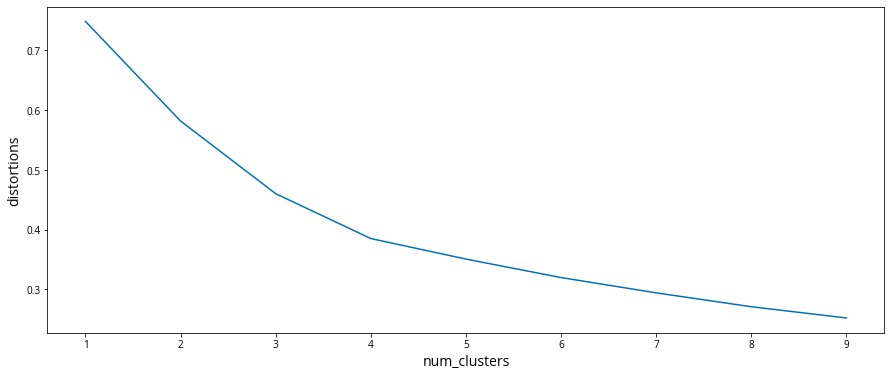

In [28]:
plot_elbow_distortions(data)

/home/kcavagnolo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: setting an array element with a sequence.

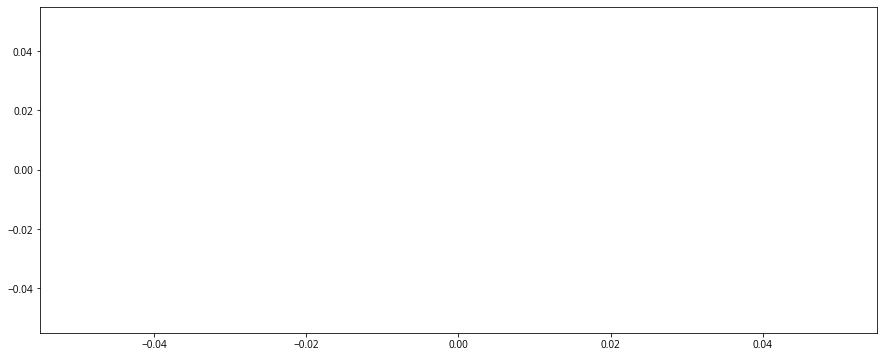

In [29]:
plot_clusters(data, 4)

## Uniform Clusters

In [30]:
xs = []
ys = []
bounds = [((1, 3), (0, 1)), ((0, 1), (2.5, 3.5)), ((2, 4), (1.5, 3.5))]
for bound in bounds:
    xs.append(np.random.uniform(bound[0][0], bound[0][1], 10))
    ys.append(np.random.uniform(bound[1][0], bound[1][1], 10))
xs = np.concatenate(xs)
ys = np.concatenate(ys)
data = list(zip(xs, ys))

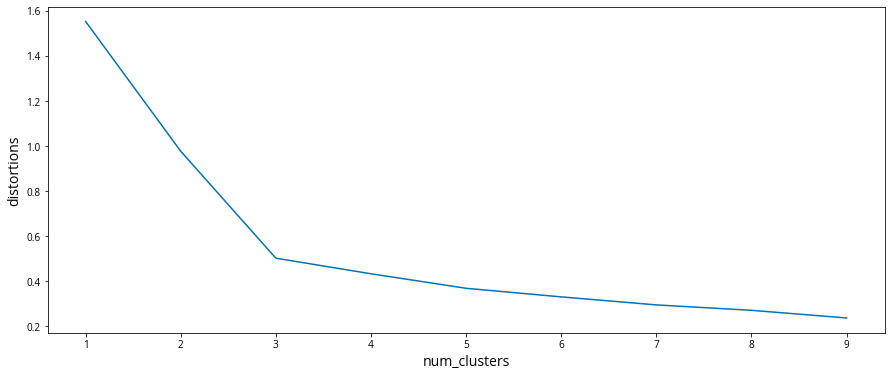

In [31]:
plot_elbow_distortions(data)

/home/kcavagnolo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: setting an array element with a sequence.

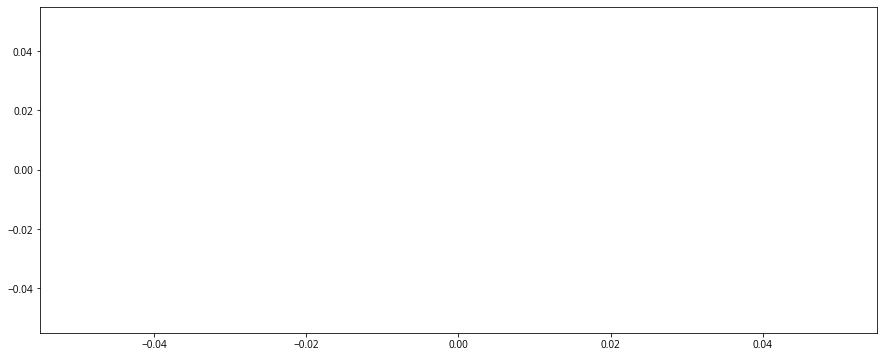

In [32]:
plot_clusters(data, 3)

# Dominant Image Color

## Data

In [33]:
# Read batman image and print dimensions
batman_image = img.imread("datasets/batman.jpg")
print(batman_image.shape)
batman_df = pd.DataFrame(batman_image.reshape(-1, 3), columns={"r": 0, "g": 1, "b": 2})
for c in batman_df.columns:
    batman_df[c] = batman_df[c].astype(float)
batman_df.dtypes

(169, 269, 3)


r    float64
g    float64
b    float64
dtype: object

## Whitening

In [34]:
batman_whitened = pd.DataFrame(
    sp.cluster.vq.whiten(batman_df), columns=batman_df.columns
)

## Elbow Selection

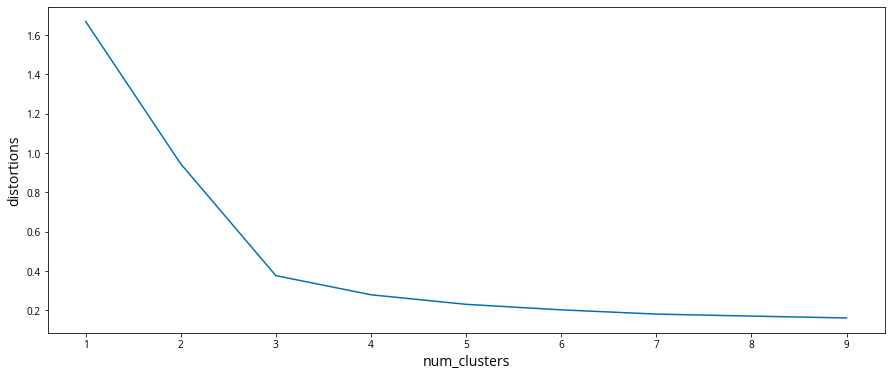

In [35]:
plot_elbow_distortions(batman_whitened)

As expected, there are three distinct clusters representing RGB.

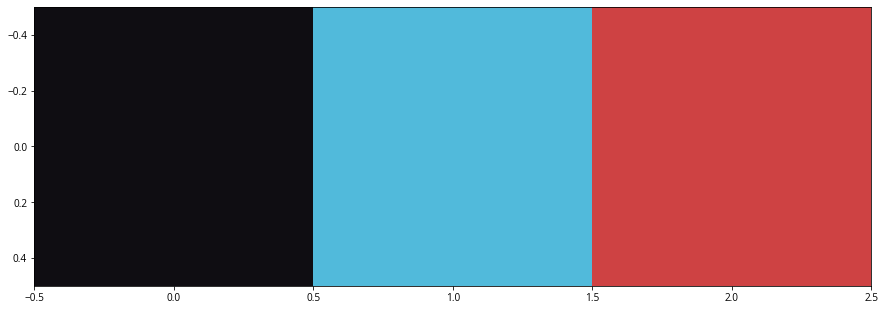

In [36]:
colors = []
cluster_centers, distortion = kmeans(batman_df[["r", "g", "b"]], 3)

# Get standard deviations of each color
r_std, g_std, b_std = batman_whitened[["r", "g", "b"]].std()
for cluster_center in cluster_centers:
    scaled_r, scaled_g, scaled_b = cluster_center
    # Convert each standardized value to scaled value
    colors.append(
        (
            scaled_r * r_std / 255.0,
            scaled_g * g_std / 255.0,
            scaled_b * b_std / 255.0,
        )
    )

# Display colors of cluster centers
plt.imshow([colors])
plt.show()

# Movie Plots

## Data

In [37]:
movies = pd.read_csv("datasets/movies_plot.csv")
movies.sample(5)

,Title,Plot
424,Warrior of the Lost World,The Rider arrives on his advanced motorcycle w...
271,Dangerous Millions,Combat pilot turned soldier of fortune Jack Cl...
553,Boiler Room,"In 1999, Seth Davis (Ribisi), a 19-year-old Qu..."
685,"Me, Myself & Irene",Charlie Baileygates (Jim Carrey) is a veteran ...
865,The Raging Tide,The film tells of Bruno Felkin (Conte) as a Sa...


In [38]:
plots = movies.Plot.to_list()

In [39]:
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.75, max_features=50, min_df=0.1, tokenizer=remove_noise
)

# Use the .fit_transform() method on the list plots
tfidf_matrix = tfidf_vectorizer.fit_transform(plots)

In [40]:
num_clusters = 2

# Generate cluster centers through the kmeans function
cluster_centers, distortion = kmeans(tfidf_matrix.todense(), num_clusters)

# Generate terms from the tfidf_vectorizer object
terms = tfidf_vectorizer.get_feature_names()

for i in range(num_clusters):
    # Sort the terms and print top 3 terms
    center_terms = dict(zip(terms, list(cluster_centers[i])))
    sorted_terms = sorted(center_terms, key=center_terms.get, reverse=True)
    print(sorted_terms[:3])

['one', 'back', 'two']
['film', 'life', 'new']
